In [1]:
# Kernel tf_gpu
# Initial code and auxiliar functions. Don't pay attention to this
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
#! pip install untangle
# The easiest way to parse xml files I have found.
import untangle

In [3]:
# dlib image object detection dataset xml file format
basepath='/media/francisco/FREEDOS/datasets/pictures/indoor_object_detection_dataset/faster_bounding_box_dataset/all'
filename='exit_fire.xml'
obj=untangle.parse(filename)
len(obj.dataset.images.image)

1086

In [126]:
def fillRec(img,x,y,w,h):
    for i in range(w-1):
        for j in range(h-1):
            img[y+j+1,x+i+1,0]=1

def fillRecSoftMax(img,x,y,w,h,label):
    img[y-1:y+h+2,x-1:x+w+2,    0]=0
    img[y-1:y+h+2,x-1:x+w+2,label]=1
def fillRecSoftMax_OLD(img,x,y,w,h,label):
    for i in range(w+1):
        for j in range(h+1):
            nx=x+i
            if nx>=img.shape[1]: nx=img.shape[1]-1
            if nx<0: nx=0
            ny=y+j
            if ny>=img.shape[0]: ny=img.shape[0]-1
            if ny<0: ny=0
            img[ny,nx,0]=0
            img[ny,nx,label]=1
            
def setCenter(img,top,left,width,height):
    center_x=left+width//2
    center_y=top +height//2
    y[center_y,center_x,0]=1
    
def setBlackBackground(im):
    img=im.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j,0]>0.1:
                img[i,j,:]=0
    return img
                
def getLabel(box):
    l=b.label.cdata
    if l=="fireextinguisher":
        return 1
    if l=="exit":
        return 2
    return 0
    
def plt_img(imi,imo):
    #plt.imshow(imi.reshape(height_i,width_i,3))
    plt.imshow(imi)
    width_i=imi.shape[1]
    height_i=imi.shape[0]
    #plt.show()
    #img_np=imo.reshape(height_o,width_o,3)
    img_np=imo#.reshape(height_o,width_o,3)
    img=cv2.resize(img_np,(width_i,height_i))
    #plt.imshow(img,cmap='cool',alpha=0.25)
    plt.imshow(setBlackBackground(img),alpha=0.5)


In [130]:
images=[]
labels=[]
scale=4
reduction=8
classes=3 # exit, fireextinguisher, none
for i in obj.dataset.images.image[:]:
    imgfile=os.path.join(basepath,i['file'])
    #print(imgfile)
    img=cv2.imread(imgfile)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize and 
    # normalize very important!!
    img=img/255.0
    img=cv2.resize(img, (img.shape[1]//scale, img.shape[0]//scale))
    #print(i['file'],'\t',img.shape)
    height_i=img.shape[0]
    width_i =img.shape[1]
    height_o=height_i//reduction
    width_o =width_i //reduction
    y=np.zeros((height_o,width_o,classes))
    fillRecSoftMax(y,0,0,width_o,height_o,0)
    for b in i.box:
        top   =int(b['top'   ])//scale//reduction
        left  =int(b['left'  ])//scale//reduction
        width =int(b['width' ])//scale//reduction
        height=int(b['height'])//scale//reduction
        label=getLabel(b)
        
        #setCenter(y,top,left,width,height)
        fillRecSoftMax(y,left,top,width,height,label)
        #print("  ",b.label.cdata,"\t->\t[",top,",",left,",",width,",",height,"]")
    images.append(img)
    labels.append(y)
    

In [131]:
images_np=np.array(images)
y_train=np.array(labels[:-100])
y_test =np.array(labels[:100])
print(images_np.shape)
x_train=images_np[:-100]
x_test =images_np[:100]
idx=random.randint(0,y_train.shape[0])
print(x_train[idx].shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.min(y_train),np.max(y_train))

(1086, 180, 320, 3)
(180, 320, 3)
(986, 180, 320, 3)
(986, 22, 40, 3)
(100, 180, 320, 3)
(100, 22, 40, 3)
0.0 1.0


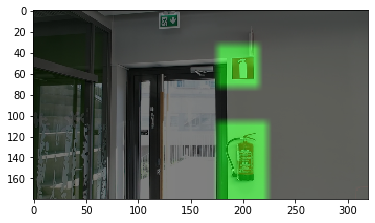

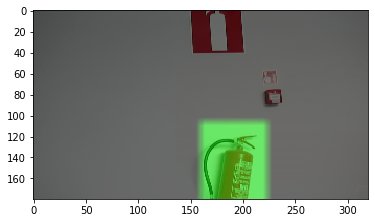

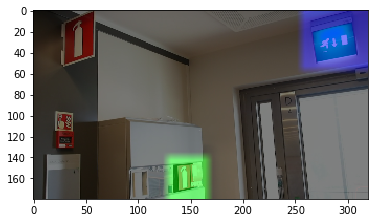

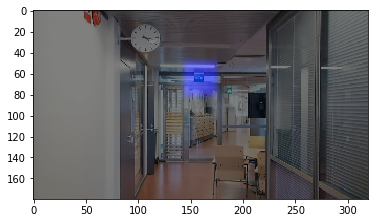

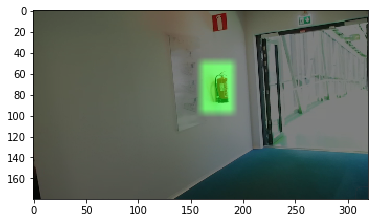

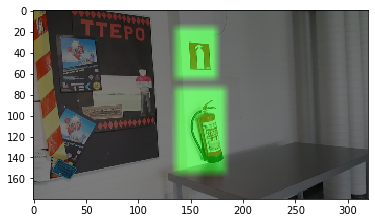

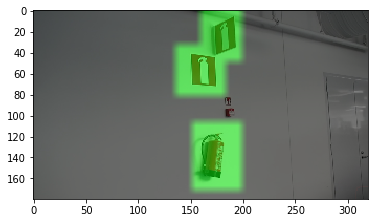

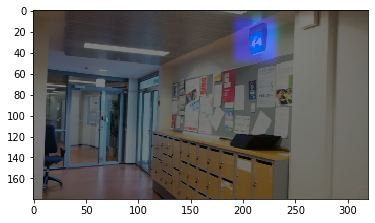

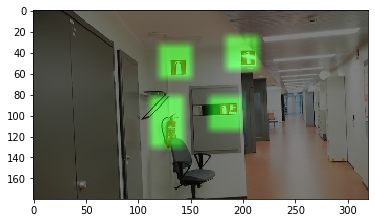

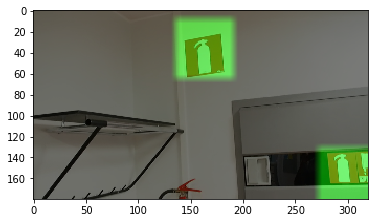

In [132]:
for i in range(10):
    idx=random.randint(0,y_train.shape[0])
    plt.figure()
    plt_img(x_train[idx],y_train[idx])
plt.show()

In [133]:
# keras 2.2.4-tf
import tensorflow.keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense, Dropout,Flatten, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import tensorflow as tf
print("tf=   ",tf.__version__)
print("keras=",tf.keras.__version__)

tf=    2.1.0
keras= 2.2.4-tf


In [134]:
def image_softmax(input):
    label_dim = -1
    d = K.exp(input - K.max(input, axis=label_dim, keepdims=True))
    return d / K.sum(d, axis=label_dim, keepdims=True)

__EPS = 1e-5
def image_categorical_crossentropy(y_true, y_pred):
    y_pred = K.clip(y_pred, __EPS, 1 - __EPS)
    return -K.mean(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))

In [135]:
#input_shape=(360,640,3)
# Dynamic Imput size
#input_shape=(int(360/2),int(640/2),3)
input_shape=(None,None,3)
model = Sequential()

input= Input(input_shape)
x=input
# Without BatchNormalization the model doesn't seem to learn
# (11/04/2019) actually I hadn't normalized the color images just I had to divide by 255
# (11/04/2019) with dropouts and without BatchNorm learn but slowly
x = Conv2D(32, 5,padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#model.add(Dropout(0.5))

x = Conv2D(32, 3,padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#model.add(Dropout(0.5))

x = Conv2D(32, 3,padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#model.add(Dropout(0.5))

# receptive field aproximation 8(reduction)x3(convolution size)=24
#model.add(Conv2D(1, 3, 3, activation='sigmoid',border_mode='same'))
# receptive field aproximation 8(reduction)x5(convolution size)=40
# receptive field aproximation 8(reduction)x7(convolution size)=56
x = Conv2D(32, 7,padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(32, 3,padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Last layer n filters = n outputs
x = Conv2D(classes, 1, activation=image_softmax,padding='same')(x)
model=Model(input,x)

In [136]:
model.compile(loss=image_categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, None, None, 32)    2432      
_________________________________________________________________
batch_normalization_81 (Batc (None, None, None, 32)    128       
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, None, None, 32)    0         
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
batch_normalization_82 (Batc (None, None, None, 32)    128 

In [137]:
batch_size=100
epochs=250
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=[x_test,y_test],
                    verbose=1)

Train on 986 samples, validate on 100 samples
Epoch 1/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.4299 - accuracy: 0.3893 - val_loss: 0.4200 - val_accuracy: 0.0636
Epoch 2/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.4045 - accuracy: 0.3686 - val_loss: 0.4196 - val_accuracy: 0.0581
Epoch 3/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.4003 - accuracy: 0.3492 - val_loss: 0.4199 - val_accuracy: 0.1241
Epoch 4/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3976 - accuracy: 0.3766 - val_loss: 0.4196 - val_accuracy: 0.1106
Epoch 5/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3957 - accuracy: 0.3329 - val_loss: 0.4197 - val_accuracy: 0.0868
Epoch 6/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3947 - accuracy: 0.3405 - val_loss: 0.4203 - val_accuracy: 0.2477
Epoch 7/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3933 

986/986 [==============================] - 3s 3ms/sample - loss: 0.3789 - accuracy: 0.3665 - val_loss: 0.3825 - val_accuracy: 0.3730
Epoch 113/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3786 - accuracy: 0.3725 - val_loss: 0.3830 - val_accuracy: 0.2787
Epoch 114/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3785 - accuracy: 0.3808 - val_loss: 0.3820 - val_accuracy: 0.4416
Epoch 115/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3784 - accuracy: 0.3502 - val_loss: 0.3827 - val_accuracy: 0.3826
Epoch 116/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3790 - accuracy: 0.3823 - val_loss: 0.3829 - val_accuracy: 0.3131
Epoch 117/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3787 - accuracy: 0.3257 - val_loss: 0.3832 - val_accuracy: 0.3755
Epoch 118/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3786 - accuracy: 0.3651 - val_loss: 0.3827 - val_ac

Epoch 168/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3771 - accuracy: 0.3487 - val_loss: 0.3809 - val_accuracy: 0.4655
Epoch 169/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3772 - accuracy: 0.3745 - val_loss: 0.3811 - val_accuracy: 0.5615
Epoch 170/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3770 - accuracy: 0.3694 - val_loss: 0.3818 - val_accuracy: 0.4896
Epoch 171/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3772 - accuracy: 0.3641 - val_loss: 0.3828 - val_accuracy: 0.4402
Epoch 172/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3769 - accuracy: 0.3719 - val_loss: 0.3811 - val_accuracy: 0.3535
Epoch 173/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3769 - accuracy: 0.3360 - val_loss: 0.3827 - val_accuracy: 0.3479
Epoch 174/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3768 - accuracy: 0.3862 - val_loss: 0

Epoch 224/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3762 - accuracy: 0.3941 - val_loss: 0.3819 - val_accuracy: 0.3870
Epoch 225/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3761 - accuracy: 0.3517 - val_loss: 0.3812 - val_accuracy: 0.4591
Epoch 226/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3759 - accuracy: 0.3862 - val_loss: 0.3798 - val_accuracy: 0.3994
Epoch 227/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3757 - accuracy: 0.3685 - val_loss: 0.3805 - val_accuracy: 0.4459
Epoch 228/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3757 - accuracy: 0.3409 - val_loss: 0.3797 - val_accuracy: 0.3810
Epoch 229/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3756 - accuracy: 0.3627 - val_loss: 0.3796 - val_accuracy: 0.3636
Epoch 230/250
986/986 [==============================] - 3s 3ms/sample - loss: 0.3756 - accuracy: 0.3725 - val_loss: 0

In [138]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.37680710292974784
Train accuracy: 0.33540592
Test loss: 0.3798516809940338
Test accuracy: 0.3323182


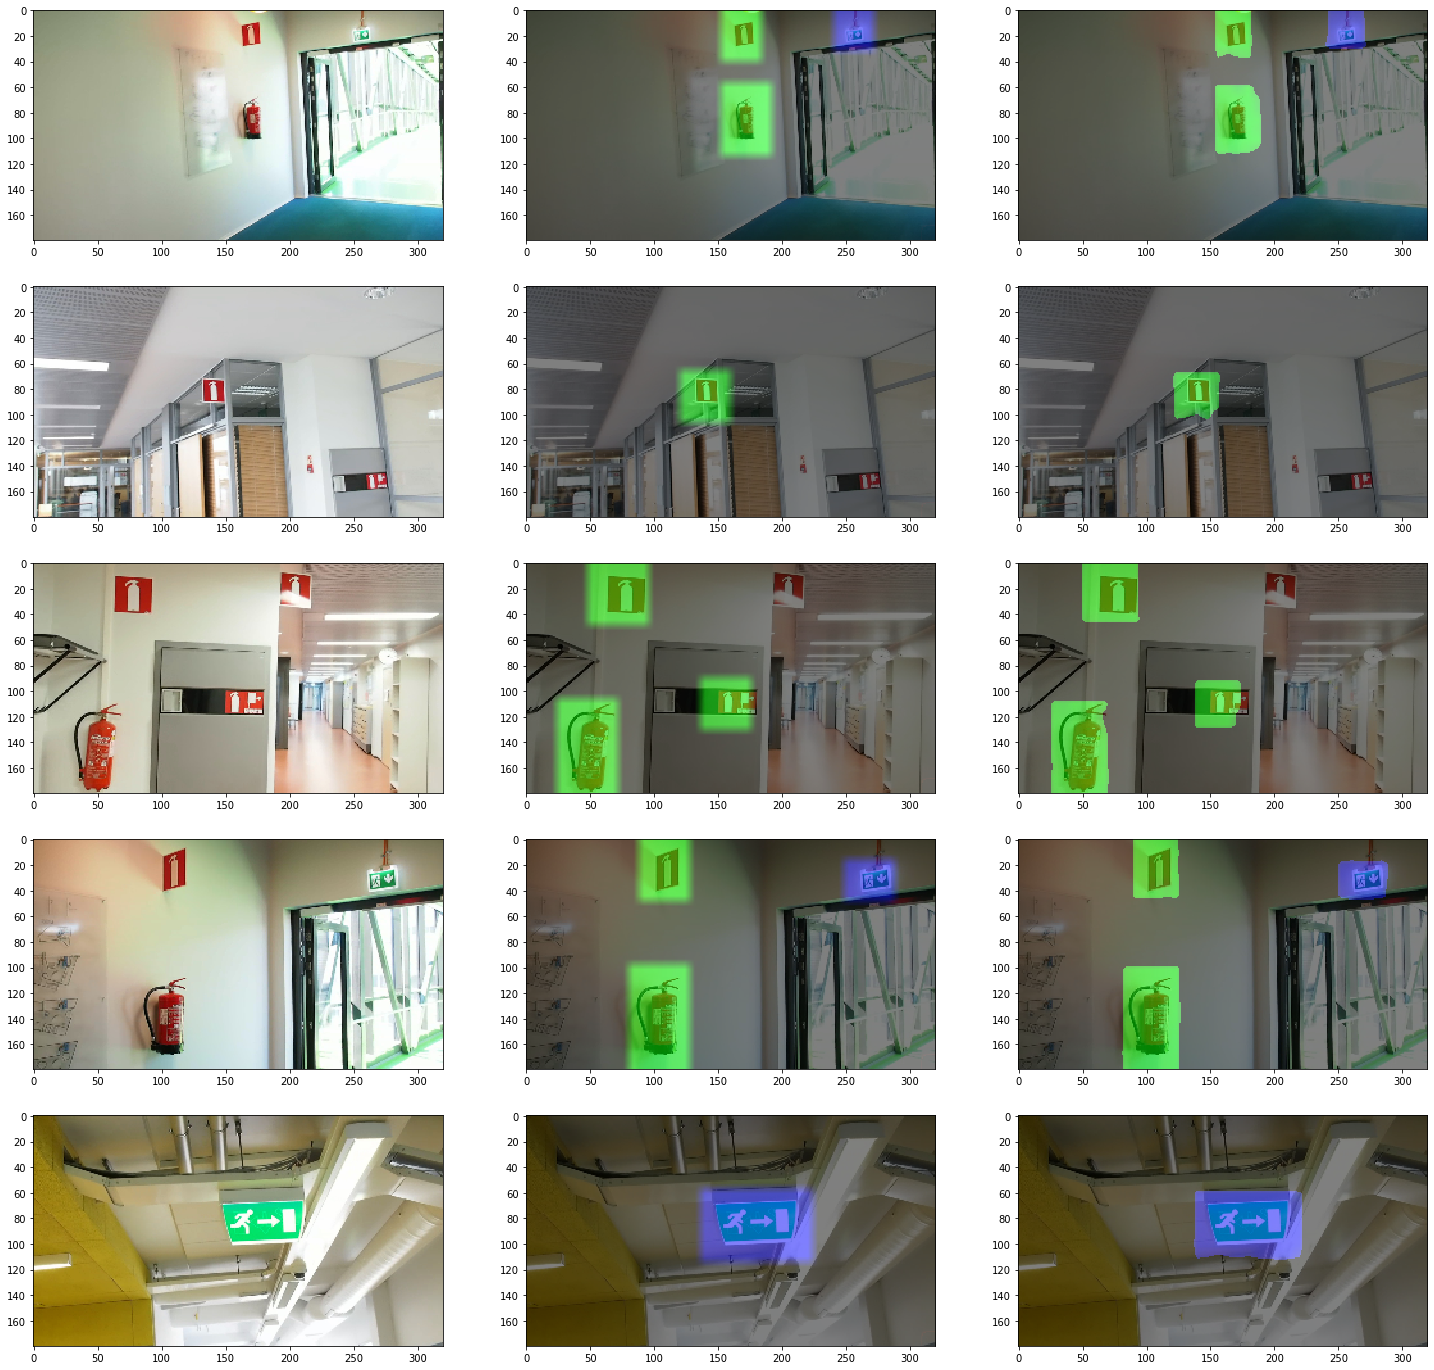

In [139]:
plt.figure(1,figsize=(25,50))
y_pred=model.predict(x_train)
y_dif=np.abs(y_pred-y_train)
for i in range(5):
    idx=random.randint(0,x_train.shape[0])
    #print(np.max(y_pred[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_train[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    #plt.imshow(x_train[idx].reshape(height_i,width_i,3))
    #img_np=setBlackBackground(y_train[idx].reshape(height_o,width_o,3))
    #img=cv2.resize(img_np,(width_i,height_i))
    #plt.imshow(setBlackBackground(img),alpha=0.5)
    plt_img(x_train[idx],y_train[idx])
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    #plt.imshow(setBlackBackground(y_pred[idx].reshape(height_o,width_o,3)))
    plt_img(x_train[idx],y_pred[idx])
    #plt.show()
    #plt.imshow(y_dif[idx].reshape(height_o,width_o),cmap="gray_r")
plt.show()

In [149]:
print("TEST")
print(x_test.shape)
y_predf=model.predict(x_test)
y_pred=y_predf>0.5
y_dif=np.abs(y_pred-y_test)

TEST
(100, 180, 320, 3)


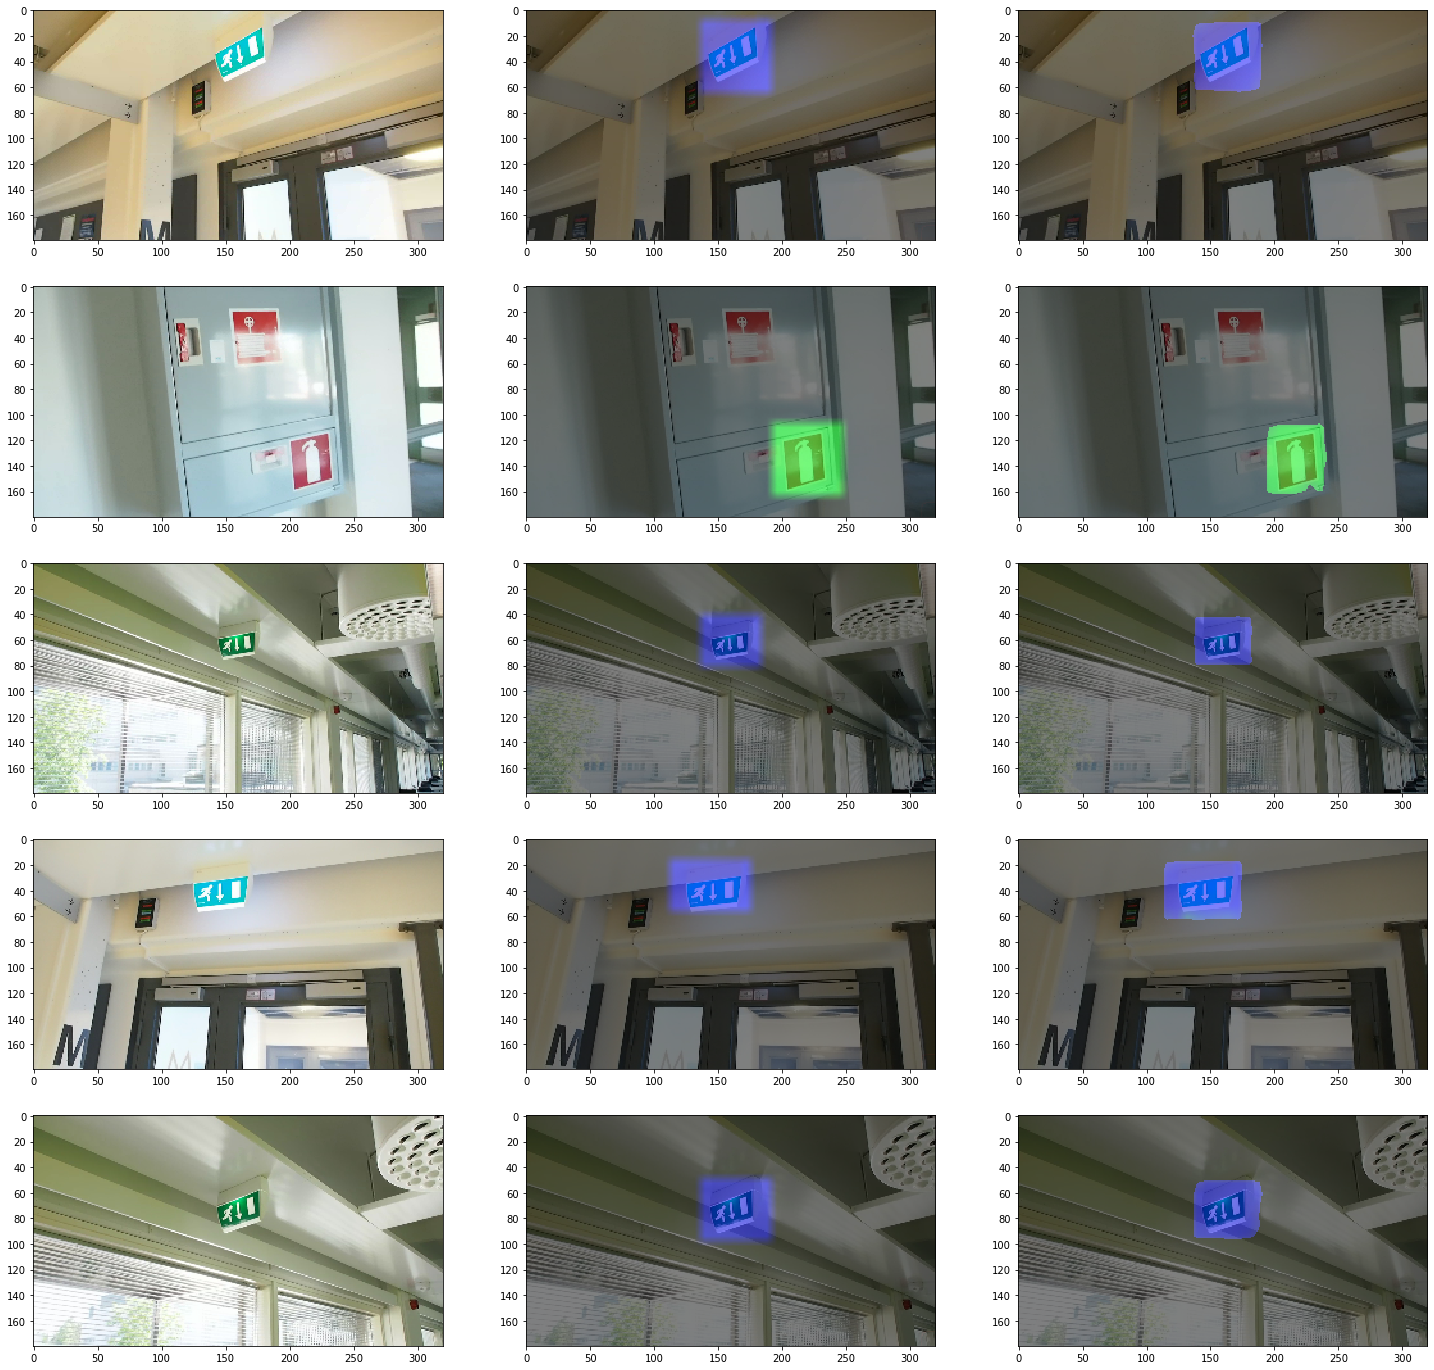

In [150]:
plt.figure(1,figsize=(25,50))
for i in range(5):
    idx=random.randint(0,x_test.shape[0])
    #print(np.max(y_predf[idx]))
    #print(np.sum(y_dif[idx]/(height_o*width_o)))
    plt.subplot(10, 3, i*3+1)
    plt.imshow(x_test[idx].reshape(height_i,width_i,3))
    #plt.show()
    plt.subplot(10, 3, i*3+2)
    plt_img(x_test[idx],y_test[idx])
    #plt.show()
    plt.subplot(10, 3, i*3+3)
    plt_img(x_test[idx],y_predf[idx])
plt.show()

In [1]:
idx=random.randint(0,x_test.shape[0])
i=obj.dataset.images.image[idx]
imgfile=os.path.join(basepath,i['file'])
img=cv2.imread(imgfile)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)/255
nf=7
plt.figure(1,figsize=(nf*2,nf*4))
for i in range(0,nf):
    #print(img.shape)
    plt.subplot(nf, 2, i*2+1)
    plt.imshow(img)
    y_predf=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
    #print(y_predf.shape)
    plt.subplot(nf, 2, i*2+2)
    plt_img(img,y_predf[0])
    img=cv2.resize(img,(int(img.shape[1]*0.7),int(img.shape[0]*0.7)))
plt.show()

NameError: name 'random' is not defined

In [144]:
y_predf=model.predict(img.reshape(1,img.shape[0],img.shape[1],img.shape[2]))
print(img.shape)
print(y_predf.shape)

(58, 104, 3)
(1, 7, 13, 3)


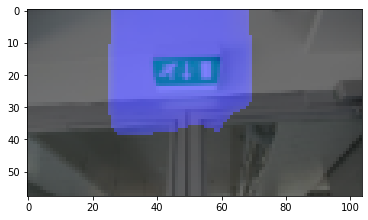

In [146]:
#plt.imshow(y_predf[0].reshape(y_predf.shape[1],y_predf.shape[2],3))
plt_img(img,y_predf[0])

plt.show()